\##Detecting Hate Speech in Tweets using NLP Techniques

In [ ]:
# installing libraries
!pip install transformers
!pip install keras

In [ ]:
# importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sns
from sklearn.metrics import confusion_matrix

import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
from nltk.tokenize import TweetTokenizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

from wordcloud import WordCloud, STOPWORDS

import re
import string
import nltk


In [ ]:
# Setting the device if a GPU is available, it uses the GPU for computation; otherwise, it uses the CPU.
device_for_CW = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_for_CW

device(type='cpu')

In [ ]:
# Loading the dataset

from google.colab import drive

drive.mount('/content/drive')
tweets_df_train = pd.read_csv('/content/drive/MyDrive/train_E6oV3lV.csv')
tweets_df_test= pd.read_csv('/content/drive/MyDrive/test_tweets_anuFYb8.csv')

Mounted at /content/drive


In [ ]:
tweets_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [ ]:
tweets_df_train.describe()

id         label
count  31962.000000  31962.000000
mean   15981.500000      0.070146
std     9226.778988      0.255397
min        1.000000      0.000000
25%     7991.250000      0.000000
50%    15981.500000      0.000000
75%    23971.750000      0.000000
max    31962.000000      1.000000

In [ ]:
tweets_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

# processed_tweets function converts all tweets to lowercase and then remove all URLs, stopwords, twitter usernames
# (strings beginning with '@'), non-alphanumeric characters, except for spaces and tabs, removing stings beginning with "http",
# and removing strings beggining of tweet 'rt'.
import re

def processed_tweets(df):
    # Convert all string characters to lower-case
    df["tweet"] = df["tweet"].str.lower()

    # Remove URLs
    df["tweet"] = df["tweet"].str.replace(r'http\S+', '', regex=True)

    # Remove special characters, usernames, and 'rt'
    df["tweet"] = df["tweet"].str.replace(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", regex=True)

    return df

#Function to remove all stopwords from the tweets
def remove_stopwords_from_tweets(df):
    stop_words_from_tweets = set(stopwords.words('english'))
    df["tweet"] = df["tweet"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words_from_tweets]))
    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
processed_twittertrain = processed_tweets(tweets_df_train)

In [ ]:
processed_twittertrain2 = remove_stopwords_from_tweets(processed_twittertrain)

In [ ]:
processed_twittertrain2

id  label                                              tweet
0          1      0  father dysfunctional selfish drags kids dysfun...
1          2      0  thanks lyft credit cant use cause dont offer w...
2          3      0                                     bihday majesty
3          4      0                        model love u take u time ur
4          5      0                      factsguide society motivation
...      ...    ...                                                ...
31957  31958      0                                      ate isz youuu
31958  31959      0  see nina turner airwaves trying wrap mantle ge...
31959  31960      0    listening sad songs monday morning otw work sad
31960  31961      1    sikh temple vandalised calgary wso condemns act
31961  31962      0                                       thank follow

[31962 rows x 3 columns]

In [ ]:
processed_twittertrain2["label"].value_counts()
#We can see that there is a major class imbalance, where class 1 is the minority. Therefore, we will implement oversampling and undersampling to ensure models trained are less biased.


label
0    29720
1     2242
Name: count, dtype: int64

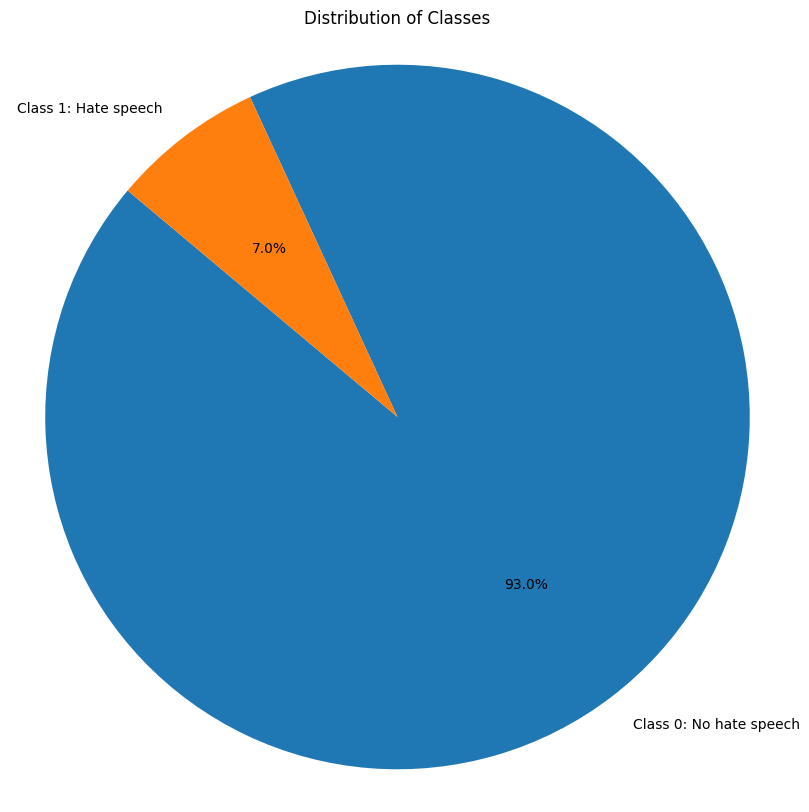

In [ ]:

# Data from twitter_train
labels = ['Class 0: No hate speech', 'Class 1: Hate speech']
sizes = [29720, 2242]


plt.figure(figsize=(10, 10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%' ,startangle=140)
plt.axis('equal')
plt.title('Distribution of Classes')
plt.show()

In [ ]:
processed_twittertest = processed_tweets(tweets_df_test)

In [ ]:
processed_twittertest2 = processed_tweets(processed_twittertest)

In [ ]:
processed_twittertest2

id                                              tweet
0      31963  studiolife aislife requires passion dedication...
1      31964    white supremacists want everyone to see the ...
2      31965  safe ways to heal your acne    altwaystoheal h...
3      31966  is the hp and the cursed child book up for res...
4      31967    3rd bihday to my amazing hilarious nephew el...
...      ...                                                ...
17192  49155  thought factory leftright polarisation trump u...
17193  49156  feeling like a mermaid  hairflip neverready fo...
17194  49157  hillary campaigned today in ohioomg amp used w...
17195  49158  happy at work conference right mindset leads t...
17196  49159  my   song so glad free download  shoegaze newm...

[17197 rows x 2 columns]

In [ ]:
processed_twittertest

id                                              tweet
0      31963  studiolife aislife requires passion dedication...
1      31964    white supremacists want everyone to see the ...
2      31965  safe ways to heal your acne    altwaystoheal h...
3      31966  is the hp and the cursed child book up for res...
4      31967    3rd bihday to my amazing hilarious nephew el...
...      ...                                                ...
17192  49155  thought factory leftright polarisation trump u...
17193  49156  feeling like a mermaid  hairflip neverready fo...
17194  49157  hillary campaigned today in ohioomg amp used w...
17195  49158  happy at work conference right mindset leads t...
17196  49159  my   song so glad free download  shoegaze newm...

[17197 rows x 2 columns]

In [ ]:
processed_twittertest2

id                                              tweet
0      31963  studiolife aislife requires passion dedication...
1      31964    white supremacists want everyone to see the ...
2      31965  safe ways to heal your acne    altwaystoheal h...
3      31966  is the hp and the cursed child book up for res...
4      31967    3rd bihday to my amazing hilarious nephew el...
...      ...                                                ...
17192  49155  thought factory leftright polarisation trump u...
17193  49156  feeling like a mermaid  hairflip neverready fo...
17194  49157  hillary campaigned today in ohioomg amp used w...
17195  49158  happy at work conference right mindset leads t...
17196  49159  my   song so glad free download  shoegaze newm...

[17197 rows x 2 columns]

In [ ]:
processed_twittertrain2["length"] = processed_twittertrain2["tweet"].apply(lambda x: len(x))
processed_twittertest2["length"] = processed_twittertest2["tweet"].apply(lambda x: len(x))

def count_words(sentence):
    return len(sentence.split())

processed_twittertrain2["word_count"] = processed_twittertrain2["tweet"].apply(count_words)
processed_twittertest2["word_count"] = processed_twittertest2["tweet"].apply(count_words)

In [ ]:
processed_twittertrain2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          31962 non-null  int64 
 1   label       31962 non-null  int64 
 2   tweet       31962 non-null  object
 3   length      31962 non-null  int64 
 4   word_count  31962 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.2+ MB


In [ ]:
processed_twittertrain2["word_count"].sum()

253102

In [ ]:
processed_twittertrain2["length"].sum()

1737515

In [ ]:
processed_twittertrain2.describe()

id         label        length    word_count
count  31962.000000  31962.000000  31962.000000  31962.000000
mean   15981.500000      0.070146     54.361899      7.918841
std     9226.778988      0.255397     22.344034      3.304946
min        1.000000      0.000000      0.000000      0.000000
25%     7991.250000      0.000000     37.000000      5.000000
50%    15981.500000      0.000000     56.000000      8.000000
75%    23971.750000      0.000000     71.000000     10.000000
max    31962.000000      1.000000    127.000000     24.000000

In [ ]:
processed_twittertest2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          17197 non-null  int64 
 1   tweet       17197 non-null  object
 2   length      17197 non-null  int64 
 3   word_count  17197 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 537.5+ KB


In [ ]:
processed_twittertest2.describe()

id        length    word_count
count  17197.000000  17197.000000  17197.000000
mean   40561.000000     73.859859     12.083910
std     4964.490625     27.833411      5.425594
min    31963.000000      8.000000      1.000000
25%    36262.000000     52.000000      8.000000
50%    40561.000000     76.000000     11.000000
75%    44860.000000     95.000000     16.000000
max    49159.000000    138.000000     32.000000

explanatory data analysis

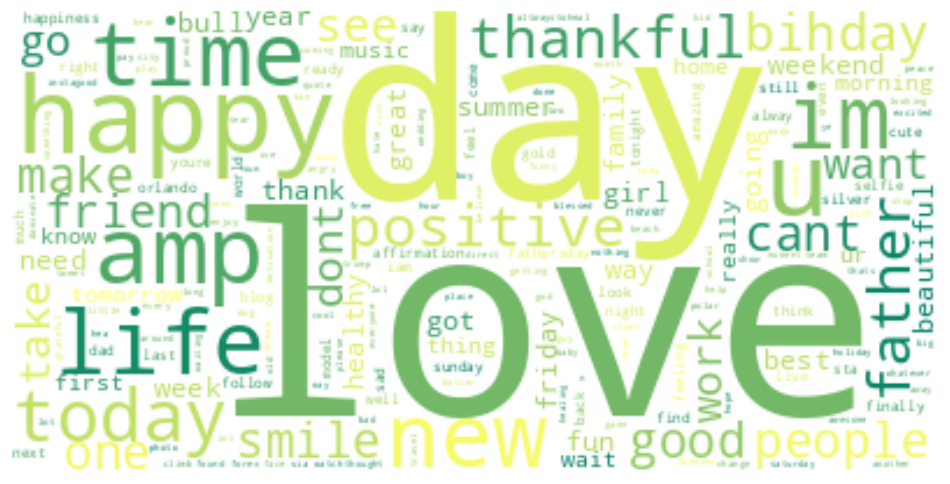

In [ ]:
# Filter out positive words
positive_text = " ".join(processed_twittertrain2["tweet"][processed_twittertrain2.label == 0])

# Generate word cloud with positive words theme
positive_cloud_tweets = WordCloud(stopwords=STOPWORDS,
                           background_color="white",
                           collocations=False,
                           colormap='summer').generate(positive_text)

# Plot the positive word cloud
plt.figure(figsize=(12, 12))
plt.imshow(positive_cloud_tweets, interpolation= 'bilinear')
plt.axis('off')
plt.show()



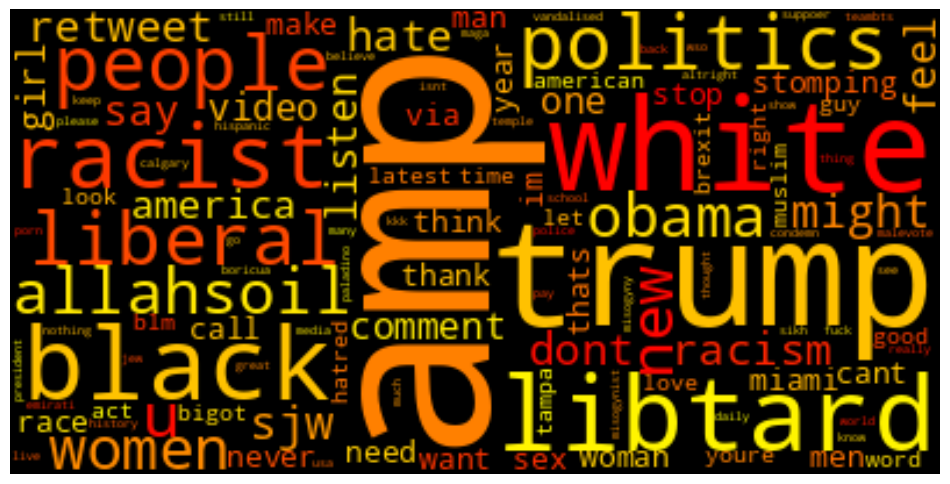

In [ ]:
# Filter out negative words
negative_text = " ".join(processed_twittertrain2["tweet"][processed_twittertrain2["label"] == 1])

# Generate word cloud with black background
negative_cloud_tweets = WordCloud(stopwords=STOPWORDS,
                           background_color="black",
                           collocations=False,
                           colormap='autumn').generate(negative_text)

# Plot the negative word cloud pf tweets
plt.figure(figsize=(12, 12))
plt.imshow(negative_cloud_tweets, interpolation='bilinear')
plt.axis('off')
plt.show()

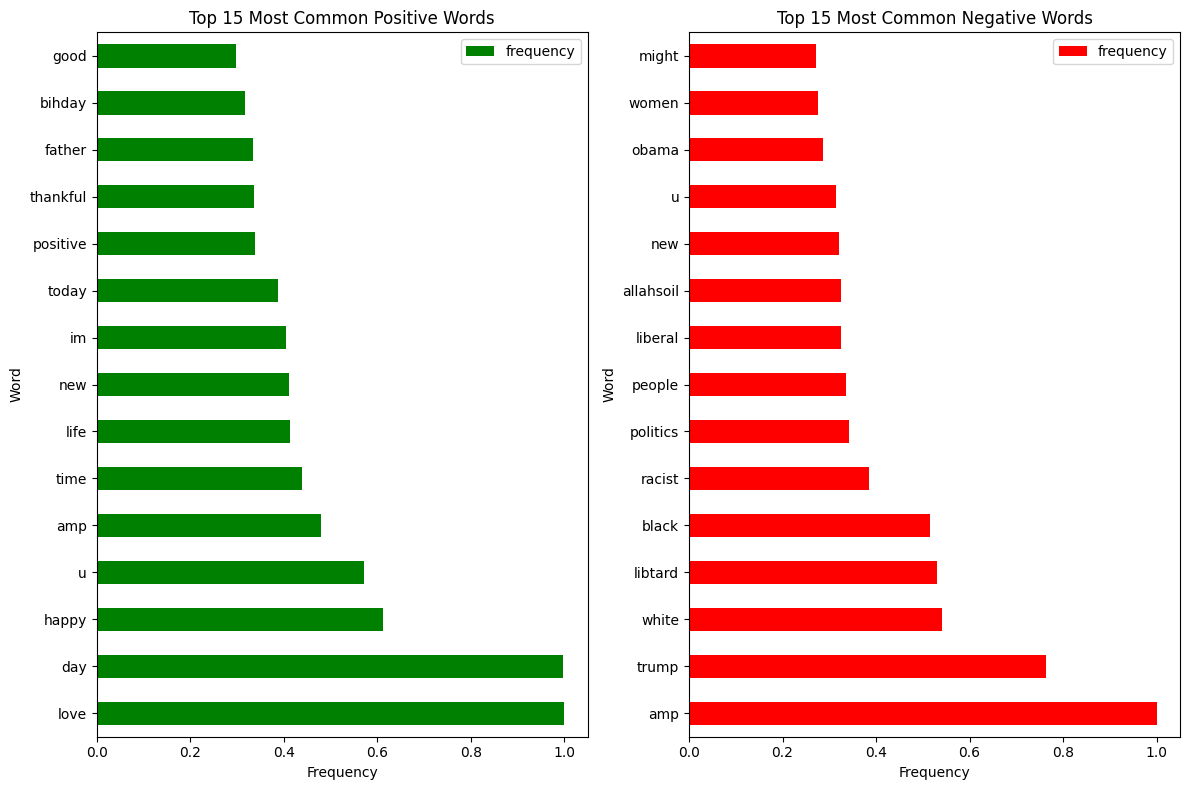

In [ ]:
# Extract word frequencies for positive tweets
pos_word_freq = pd.DataFrame.from_dict(positive_cloud_tweets.words_, orient='index').reset_index()
pos_word_freq.columns = ['word', 'frequency']
pos_word_freq = pos_word_freq.sort_values(by='frequency', ascending=False)

# top 15 words to display
top_n = 15

# Plot bar chart of top 15 positive words
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
top_words_positive = pos_word_freq.head(top_n)
top_words_positive.plot(kind='barh', x='word', y='frequency', color='green', ax=plt.gca())
plt.title(f'Top {top_n} Most Common Positive Words')
plt.xlabel('Frequency')
plt.ylabel('Word')

# Extract word frequencies for negative tweets
neg_word_freq = pd.DataFrame.from_dict(negative_cloud_tweets.words_, orient='index').reset_index()
neg_word_freq.columns = ['word', 'frequency']
neg_word_freq = neg_word_freq.sort_values(by='frequency', ascending=False)

# Plot bar chart of top 15 negative words
plt.subplot(1, 2, 2)
top_words_negative = neg_word_freq.head(top_n)
top_words_negative.plot(kind='barh', x='word', y='frequency', color='red', ax=plt.gca())
plt.title(f'Top {top_n} Most Common Negative Words')
plt.xlabel('Frequency')
plt.ylabel('Word')

plt.tight_layout()
plt.show()



Sampling

In [ ]:
# Oversampling training set

In [ ]:
processed_twittertrain2_0 = processed_twittertrain2[processed_twittertrain2.label==0]
processed_twittertrain2_1 = processed_twittertrain2[processed_twittertrain2.label==1]

In [ ]:
cleaned_twittertrain_1_oversample = resample(processed_twittertrain2_1,
                                           n_samples = len(processed_twittertrain2_0),
                                           replace = True,
                                           random_state = 213)

In [ ]:
oversample_train = pd.concat([cleaned_twittertrain_1_oversample, processed_twittertrain2_0])

In [ ]:

oversample_train["length"] = oversample_train["tweet"].apply(lambda x: len(x))

In [ ]:
oversample_train

id  label                                              tweet  \
18205  18206      1  australia japanese whaling opkillingbaythecove...   
14699  14700      1  farmer beaten land invasion crisis loteni area...   
28414  28415      1  white people expats rest us immigrants classis...   
14264  14265      1  adl hate raison detre adl always incite means ...   
28440  28441      1  goodonedean metoo lol trumpism putinism donald...   
...      ...    ...                                                ...   
31956  31957      0     fishing tomorrow carnt wait first time 2 years   
31957  31958      0                                      ate isz youuu   
31958  31959      0  see nina turner airwaves trying wrap mantle ge...   
31959  31960      0    listening sad songs monday morning otw work sad   
31961  31962      0                                       thank follow   

       length  word_count  
18205      63           5  
14699      71          11  
28414      58           8  
14264      73          11  
28440      77           9  
...       ...         ...  
31956      46           8  
31957      13           3  
31958      93          14  
31959      47           8  
31961      12           2  

[59440 rows x 5 columns]

In [ ]:
import joblib

# Save variables to file
joblib.dump(oversample_train, '/content/drive/MyDrive/oversample_trainNEW.pkl')

['/content/drive/MyDrive/oversample_trainNEW.pkl']

In [ ]:
import joblib

# Load the pickled file
oversample_train_new = joblib.load('/content/drive/MyDrive/oversample_trainNEW.pkl')

# Now you can work with the loaded data


In [ ]:
# Undersampling on training set

In [ ]:
cleaned_twittertrain_0_undersample = resample(processed_twittertrain2_0,
                                             n_samples = len(processed_twittertrain2_1),
                                             replace = True,
                                             random_state = 213)

In [ ]:
undersample_train = pd.concat([cleaned_twittertrain_0_undersample, processed_twittertrain2_1])

In [ ]:
undersample_train# Returning the length of each tweet
undersample_train["length"] = undersample_train["tweet"].apply(lambda x: len(x))

In [ ]:
undersample_train

id  label                                              tweet  \
21218  21219      0                                               make   
14560  14561      0                           know love prayers family   
8632    8633      0  taking time move house im returning new logo l...   
18695  18696      0  create police state agree due 2nd amendment op...   
11891  11892      0        arrived nsbc2016 gettingready whoelseishere   
...      ...    ...                                                ...   
31934  31935      1         lady banned kentucky mall jcpenny kentucky   
31946  31947      1  omfg im offended im mailbox im proud mailboxpr...   
31947  31948      1  dont balls hashtag say weasel away lumpy tony ...   
31948  31949      1                 makes ask anybody god oh thank god   
31960  31961      1    sikh temple vandalised calgary wso condemns act   

       length  word_count  
21218       4           1  
14560      24           4  
8632       71          10  
18695      50           8  
11891      43           4  
...       ...         ...  
31934      42           6  
31946      61           9  
31947      53           9  
31948      34           7  
31960      47           7  

[4484 rows x 5 columns]

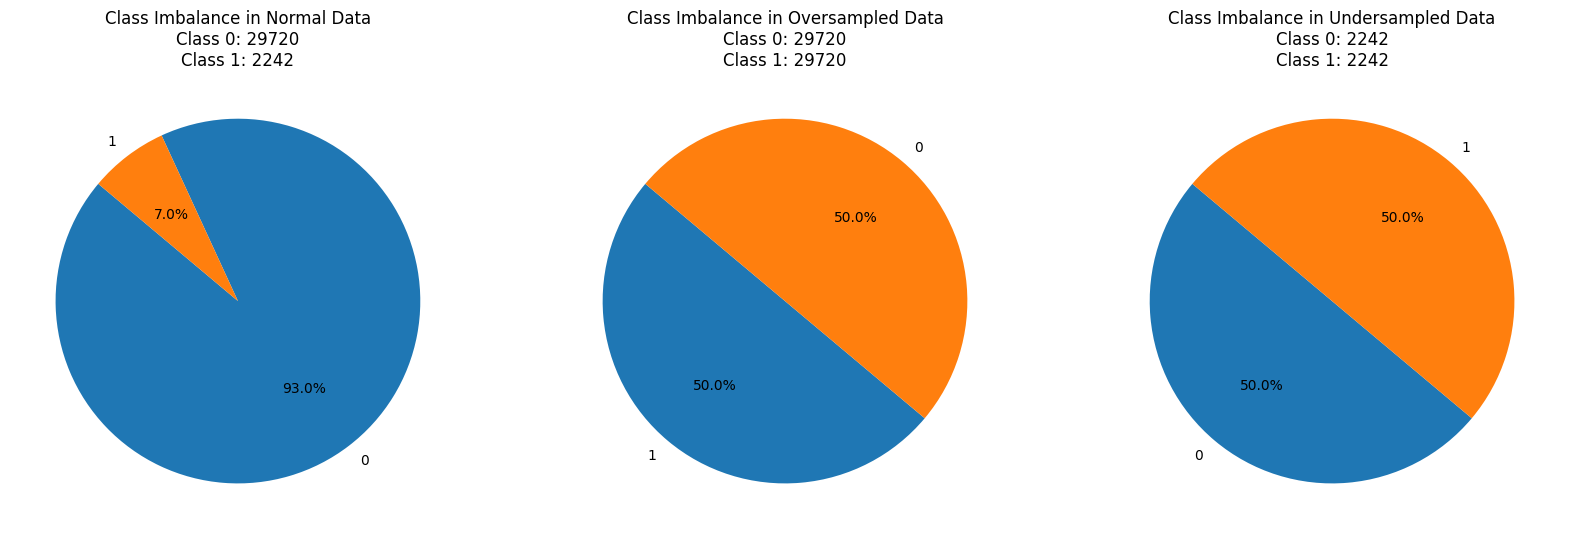

In [ ]:
# Class imbalance
class_imbalance_normal = processed_twittertrain2['label'].value_counts()
class_imbalance_oversampled = oversample_train['label'].value_counts()
class_imbalance_undersampled = undersample_train['label'].value_counts()

# Visualization
fig, axs = plt.subplots(1, 3, figsize=(20, 7))

# Plotting class imbalance in normal data
axs[0].pie(class_imbalance_normal, labels=class_imbalance_normal.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Class Imbalance in Normal Data\nClass 0: {}\nClass 1: {}'.format(class_imbalance_normal[0], class_imbalance_normal[1]))

# Plotting class imbalance in oversampled data
axs[1].pie(class_imbalance_oversampled, labels=class_imbalance_oversampled.index, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Class Imbalance in Oversampled Data\nClass 0: {}\nClass 1: {}'.format(class_imbalance_oversampled[0], class_imbalance_oversampled[1]))

# Plotting class imbalance in undersampled data
axs[2].pie(class_imbalance_undersampled, labels=class_imbalance_undersampled.index, autopct='%1.1f%%', startangle=140)
axs[2].set_title('Class Imbalance in Undersampled Data\nClass 0: {}\nClass 1: {}'.format(class_imbalance_undersampled[0], class_imbalance_undersampled[1]))

plt.show()



Machine learning pre-processing

In [ ]:
# tokenisation

In [ ]:
tokenizer_for_models = TweetTokenizer(strip_handles = True, preserve_case = False, reduce_len = True)

In [ ]:
def tokenize(text):
  return tokenizer_for_models.tokenize(text)

In [ ]:
processed_twittertrain2["tokenized_tweet"] = processed_twittertrain2["tweet"].apply(lambda x: tokenize(x))
processed_twittertest2["tokenized_tweet"] = processed_twittertest2["tweet"].apply(lambda x: tokenize(x))

undersample_train["tokenized_tweet"] = undersample_train["tweet"].apply(lambda x: tokenize(x))
oversample_train["tokenized_tweet"] = oversample_train["tweet"].apply(lambda x: tokenize(x))

In [ ]:
oversample_train

id  label                                              tweet  \
18205  18206      1  australia japanese whaling opkillingbaythecove...   
14699  14700      1  farmer beaten land invasion crisis loteni area...   
28414  28415      1  white people expats rest us immigrants classis...   
14264  14265      1  adl hate raison detre adl always incite means ...   
28440  28441      1  goodonedean metoo lol trumpism putinism donald...   
...      ...    ...                                                ...   
31956  31957      0     fishing tomorrow carnt wait first time 2 years   
31957  31958      0                                      ate isz youuu   
31958  31959      0  see nina turner airwaves trying wrap mantle ge...   
31959  31960      0    listening sad songs monday morning otw work sad   
31961  31962      0                                       thank follow   

       length  word_count                                    tokenized_tweet  
18205      63           5  [australia, japanese, whaling, opkillingbaythe...  
14699      71          11  [farmer, beaten, land, invasion, crisis, loten...  
28414      58           8  [white, people, expats, rest, us, immigrants, ...  
14264      73          11  [adl, hate, raison, detre, adl, always, incite...  
28440      77           9  [goodonedean, metoo, lol, trumpism, putinism, ...  
...       ...         ...                                                ...  
31956      46           8  [fishing, tomorrow, carnt, wait, first, time, ...  
31957      13           3                                  [ate, isz, youuu]  
31958      93          14  [see, nina, turner, airwaves, trying, wrap, ma...  
31959      47           8  [listening, sad, songs, monday, morning, otw, ...  
31961      12           2                                    [thank, follow]  

[59440 rows x 6 columns]

In [ ]:
undersample_train

id  label                                              tweet  \
21218  21219      0                                               make   
14560  14561      0                           know love prayers family   
8632    8633      0  taking time move house im returning new logo l...   
18695  18696      0  create police state agree due 2nd amendment op...   
11891  11892      0        arrived nsbc2016 gettingready whoelseishere   
...      ...    ...                                                ...   
31934  31935      1         lady banned kentucky mall jcpenny kentucky   
31946  31947      1  omfg im offended im mailbox im proud mailboxpr...   
31947  31948      1  dont balls hashtag say weasel away lumpy tony ...   
31948  31949      1                 makes ask anybody god oh thank god   
31960  31961      1    sikh temple vandalised calgary wso condemns act   

       length  word_count                                    tokenized_tweet  
21218       4           1                                             [make]  
14560      24           4                      [know, love, prayers, family]  
8632       71          10  [taking, time, move, house, im, returning, new...  
18695      50           8  [create, police, state, agree, due, 2nd, amend...  
11891      43           4  [arrived, nsbc, 2016, gettingready, whoelseish...  
...       ...         ...                                                ...  
31934      42           6  [lady, banned, kentucky, mall, jcpenny, kentucky]  
31946      61           9  [omfg, im, offended, im, mailbox, im, proud, m...  
31947      53           9  [dont, balls, hashtag, say, weasel, away, lump...  
31948      34           7         [makes, ask, anybody, god, oh, thank, god]  
31960      47           7  [sikh, temple, vandalised, calgary, wso, conde...  

[4484 rows x 6 columns]

In [ ]:
# Lemmatization technique is applied below:

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
def lemmatize(tokens):
    lemmas = [lemmatizer.lemmatize(token, pos='v') for token in tokens]
    return lemmas

In [ ]:
processed_twittertrain2['lemmas'] = processed_twittertrain2["tokenized_tweet"].apply(lemmatize)
processed_twittertest2["lemmas"] = processed_twittertest2["tokenized_tweet"].apply(lemmatize)

undersample_train["lemmas"] = undersample_train["tokenized_tweet"].apply(lemmatize)
oversample_train["lemmas"] = oversample_train["tokenized_tweet"].apply(lemmatize)

In [ ]:
processed_twittertest2

id                                              tweet  length  \
0      31963  studiolife aislife requires passion dedication...      80   
1      31964    white supremacists want everyone to see the ...      80   
2      31965  safe ways to heal your acne    altwaystoheal h...      63   
3      31966  is the hp and the cursed child book up for res...     122   
4      31967    3rd bihday to my amazing hilarious nephew el...      86   
...      ...                                                ...     ...   
17192  49155  thought factory leftright polarisation trump u...      97   
17193  49156  feeling like a mermaid  hairflip neverready fo...      82   
17194  49157  hillary campaigned today in ohioomg amp used w...     128   
17195  49158  happy at work conference right mindset leads t...      98   
17196  49159  my   song so glad free download  shoegaze newm...      58   

       word_count                                    tokenized_tweet  \
0               9  [studiolife, aislife, requires, passion, dedic...   
1              13  [white, supremacists, want, everyone, to, see,...   
2               9  [safe, ways, to, heal, your, acne, altwaystohe...   
3              21  [is, the, hp, and, the, cursed, child, book, u...   
4              15  [3rd, bihday, to, my, amazing, hilarious, neph...   
...           ...                                                ...   
17192          11  [thought, factory, leftright, polarisation, tr...   
17193          11  [feeling, like, a, mermaid, hairflip, neverrea...   
17194          17  [hillary, campaigned, today, in, ohioomg, amp,...   
17195          12  [happy, at, work, conference, right, mindset, ...   
17196           9  [my, song, so, glad, free, download, shoegaze,...   

                                                  lemmas  
0      [studiolife, aislife, require, passion, dedica...  
1      [white, supremacists, want, everyone, to, see,...  
2      [safe, ways, to, heal, your, acne, altwaystohe...  
3      [be, the, hp, and, the, curse, child, book, up...  
4      [3rd, bihday, to, my, amaze, hilarious, nephew...  
...                                                  ...  
17192  [think, factory, leftright, polarisation, trum...  
17193  [feel, like, a, mermaid, hairflip, neverready,...  
17194  [hillary, campaign, today, in, ohioomg, amp, u...  
17195  [happy, at, work, conference, right, mindset, ...  
17196  [my, song, so, glad, free, download, shoegaze,...  

[17197 rows x 6 columns]

In [ ]:
processed_twittertrain2

id  label                                              tweet  \
0          1      0  father dysfunctional selfish drags kids dysfun...   
1          2      0  thanks lyft credit cant use cause dont offer w...   
2          3      0                                     bihday majesty   
3          4      0                        model love u take u time ur   
4          5      0                      factsguide society motivation   
...      ...    ...                                                ...   
31957  31958      0                                      ate isz youuu   
31958  31959      0  see nina turner airwaves trying wrap mantle ge...   
31959  31960      0    listening sad songs monday morning otw work sad   
31960  31961      1    sikh temple vandalised calgary wso condemns act   
31961  31962      0                                       thank follow   

       length  word_count                                    tokenized_tweet  \
0          55           7  [father, dysfunctional, selfish, drags, kids, ...   
1          87          13  [thanks, lyft, credit, cant, use, cause, dont,...   
2          14           2                                  [bihday, majesty]   
3          27           7                [model, love, u, take, u, time, ur]   
4          29           3                  [factsguide, society, motivation]   
...       ...         ...                                                ...   
31957      13           3                                  [ate, isz, youuu]   
31958      93          14  [see, nina, turner, airwaves, trying, wrap, ma...   
31959      47           8  [listening, sad, songs, monday, morning, otw, ...   
31960      47           7  [sikh, temple, vandalised, calgary, wso, conde...   
31961      12           2                                    [thank, follow]   

                                                  lemmas  
0      [father, dysfunctional, selfish, drag, kid, dy...  
1      [thank, lyft, credit, cant, use, cause, dont, ...  
2                                      [bihday, majesty]  
3                    [model, love, u, take, u, time, ur]  
4                      [factsguide, society, motivation]  
...                                                  ...  
31957                                  [eat, isz, youuu]  
31958  [see, nina, turner, airwaves, try, wrap, mantl...  
31959  [listen, sad, songs, monday, morning, otw, wor...  
31960  [sikh, temple, vandalise, calgary, wso, condem...  
31961                                    [thank, follow]  

[31962 rows x 7 columns]

In [ ]:
processed_twittertest2.head()

id                                              tweet  length  \
0  31963  studiolife aislife requires passion dedication...      80   
1  31964    white supremacists want everyone to see the ...      80   
2  31965  safe ways to heal your acne    altwaystoheal h...      63   
3  31966  is the hp and the cursed child book up for res...     122   
4  31967    3rd bihday to my amazing hilarious nephew el...      86   

   word_count                                    tokenized_tweet  \
0           9  [studiolife, aislife, requires, passion, dedic...   
1          13  [white, supremacists, want, everyone, to, see,...   
2           9  [safe, ways, to, heal, your, acne, altwaystohe...   
3          21  [is, the, hp, and, the, cursed, child, book, u...   
4          15  [3rd, bihday, to, my, amazing, hilarious, neph...   

                                              lemmas  
0  [studiolife, aislife, require, passion, dedica...  
1  [white, supremacists, want, everyone, to, see,...  
2  [safe, ways, to, heal, your, acne, altwaystohe...  
3  [be, the, hp, and, the, curse, child, book, up...  
4  [3rd, bihday, to, my, amaze, hilarious, nephew...

In [ ]:
processed_twittertrain2.head()

id  label                                              tweet  length  \
0   1      0  father dysfunctional selfish drags kids dysfun...      55   
1   2      0  thanks lyft credit cant use cause dont offer w...      87   
2   3      0                                     bihday majesty      14   
3   4      0                        model love u take u time ur      27   
4   5      0                      factsguide society motivation      29   

   word_count                                    tokenized_tweet  \
0           7  [father, dysfunctional, selfish, drags, kids, ...   
1          13  [thanks, lyft, credit, cant, use, cause, dont,...   
2           2                                  [bihday, majesty]   
3           7                [model, love, u, take, u, time, ur]   
4           3                  [factsguide, society, motivation]   

                                              lemmas  
0  [father, dysfunctional, selfish, drag, kid, dy...  
1  [thank, lyft, credit, cant, use, cause, dont, ...  
2                                  [bihday, majesty]  
3                [model, love, u, take, u, time, ur]  
4                  [factsguide, society, motivation]

In [ ]:
import joblib

# Save variables to file
joblib.dump(processed_twittertrain2, '/content/drive/MyDrive/processed_twittertrain2.pkl')

['/content/drive/MyDrive/processed_twittertrain2.pkl']

Splitting the dataset into train and test sets

In [ ]:
# splitting into labels and text data
X = processed_twittertrain2["lemmas"]
y = processed_twittertrain2["label"]

X_undersample = undersample_train["lemmas"]
y_undersample = undersample_train["label"]

X_oversample = oversample_train["lemmas"]
y_oversample = oversample_train["label"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_oversample, y_oversample, test_size = 0.2, random_state = 42)

X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_undersample, y_undersample, test_size = 0.2, random_state = 42)

In [ ]:
X_test_over

13249    [surprise, news, outlets, call, opposition, ra...
4698     [good, job, reduce, talented, performer, physi...
17302    [work, develop, greencommunity, summer, fun, s...
20828    [nc, monster, law, make, republican, lawmakers...
22430             [plz, sign, japan, bully, tweet, 4taiji]
                               ...                        
11595    [restrict, duty, like, straght, jacket, pad, r...
13566    [back, red, hair, bepopular, bestpicture, cute...
6826                  [comment, reflections, ignorance, c]
30865    [nice, day, happy, grapes, weekend, sunshine, ...
23899    [hot, girl, sex, game, white, girl, sex, black...
Name: lemmas, Length: 11888, dtype: object

In [ ]:
# Lemmas
lemmas_as_strings = X_train.apply(lambda x: ' '.join(x))
lemmas_as_strings2 = X_test.apply(lambda x: ' '.join(x))
# Lemmas
lemmas_as_strings3 = X_train_under.apply(lambda x: ' '.join(x))
lemmas_as_strings4 = X_test_under.apply(lambda x: ' '.join(x))
# Lemmas
lemmas_as_strings5 = X_train_over.apply(lambda x: ' '.join(x))
lemmas_as_strings6 = X_test_over.apply(lambda x: ' '.join(x))

In [ ]:
lemmas_as_strings

12110              ive pay attention past year 8 years hes
14081    raft build salford quays pa gmw fun outdoors b...
1829     friday gdegblog friday selfie beard gayguy gay...
2769                                     fashion true fact
31818    share simple elegant businesscards design grac...
                               ...                        
29802     waltdisneyreso ashamed know alligator beach sign
5390     invite catch couldnt stop talk much love job r...
860      black professor make assumptions entire race w...
15795    lgbtqhatetrumppay total liberal trash amp path...
23654                      make people relative way africa
Name: lemmas, Length: 25569, dtype: object

Vectorisation

In [ ]:
# Count Vectorizer

In [ ]:
count_vector = CountVectorizer().fit(lemmas_as_strings) #Transforms the tokens using a transform() method into a matrix of token counts

In [ ]:
X_train_count_vectorized = count_vector.transform(lemmas_as_strings)
X_test_count_vectorized = count_vector.transform(lemmas_as_strings2)

In [ ]:
X_train_count_vectorized

<25569x32703 sparse matrix of type '<class 'numpy.int64'>'
	with 191507 stored elements in Compressed Sparse Row format>

In [ ]:
# T-Vectorizer

In [ ]:
tvector = TfidfVectorizer().fit(lemmas_as_strings)

In [ ]:
X_train_tvectorized = tvector.transform(lemmas_as_strings)
X_test_tvectorized = tvector.transform(lemmas_as_strings2)

In [ ]:
X_train_tvectorized

<25569x32703 sparse matrix of type '<class 'numpy.float64'>'
	with 191507 stored elements in Compressed Sparse Row format>

Machine learning models

In [ ]:
# baseline model
baseline = DummyClassifier(strategy="most_frequent")

In [ ]:
# Training our dummy classifier using normal data
baseline.fit(X_train, y_train)

#Training our dummy classifier using oversampled data
baseline.fit(X_train_over, y_train_over)

#Training our dummy classifier using undersampled data
baseline.fit(X_train_under, y_train_under)

DummyClassifier(strategy='most_frequent')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
y_predict_norm = baseline.predict(X_test)

y_predict_over = baseline.predict(X_test_over)

y_predict_under = baseline.predict(X_test_under)

In [ ]:
y_predict_norm

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
X_test_over

13249    [surprise, news, outlets, call, opposition, ra...
4698     [good, job, reduce, talented, performer, physi...
17302    [work, develop, greencommunity, summer, fun, s...
20828    [nc, monster, law, make, republican, lawmakers...
22430             [plz, sign, japan, bully, tweet, 4taiji]
                               ...                        
11595    [restrict, duty, like, straght, jacket, pad, r...
13566    [back, red, hair, bepopular, bestpicture, cute...
6826                  [comment, reflections, ignorance, c]
30865    [nice, day, happy, grapes, weekend, sunshine, ...
23899    [hot, girl, sex, game, white, girl, sex, black...
Name: lemmas, Length: 11888, dtype: object

In [ ]:
# Accuracies
# Baseline accuracy on normal data
baseline_acc = accuracy_score(y_predict_norm, y_test)
print("Dummy Classifier using normal data:", baseline_acc)

# Baseline accuracy on oversampled data
baseline_acc_over = accuracy_score(y_predict_over, y_test_over)
print("Dummy Classifier using oversampled data:", baseline_acc_over)

# Baseline accuracy on undersampled data
baseline_acc_under = accuracy_score(y_predict_under, y_test_under)
print("Dummy Classifier using undersampled data:", baseline_acc_under)


Dummy Classifier using normal data: 0.9286719849835758
Dummy Classifier using oversampled data: 0.5053835800807537
Dummy Classifier using undersampled data: 0.4938684503901895


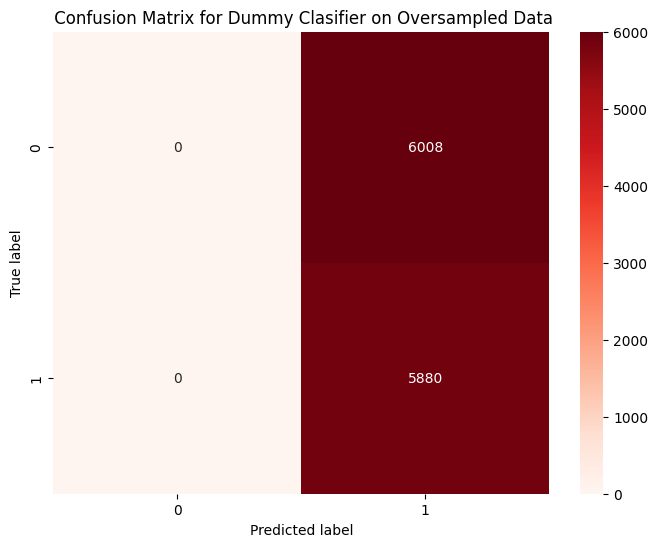

In [ ]:
# Fit Dummy Baseline on oversampled training data
baseline.fit(X_train_over, y_train_over)

# Predictions on the test set
y_predict_over = baseline.predict(X_test_over)

train_confusion_mat_over = confusion_matrix(y_test_over, y_predict_over)

plt.figure(figsize=(10, 7))
sns.heatmap(train_confusion_mat_over,  annot=True, fmt='d',cmap="Reds")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(' Confusion Matrix for Dummy Clasifier on Oversampled Data')
plt.show()


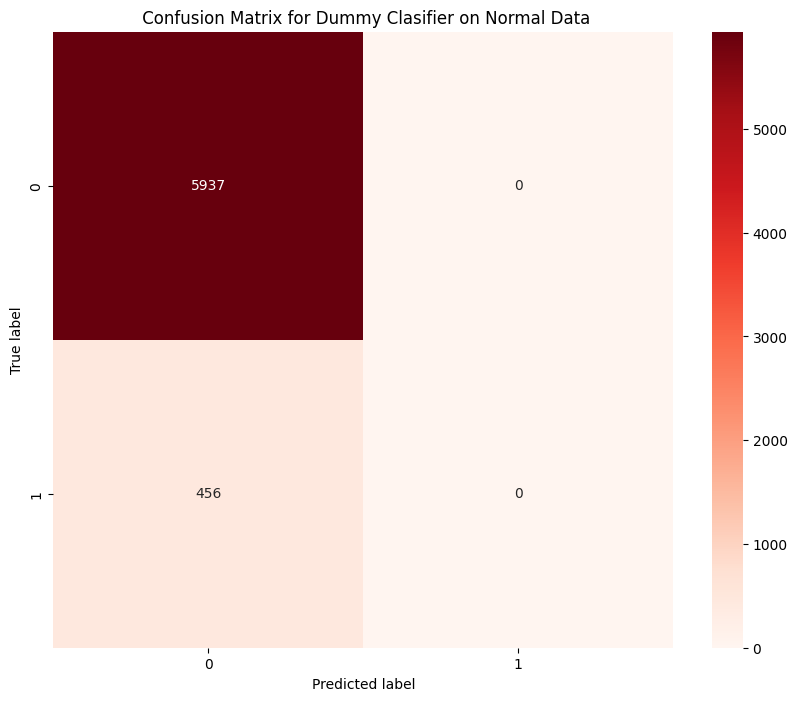

In [ ]:
# Fit Dummy Baseline on normal training data
baseline.fit(X_train, y_train)

# Predictions on the test set
y_predict_norm = baseline.predict(X_test)

confusion_mat_norm = confusion_matrix(y_test, y_predict_norm)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat_norm, annot=True,fmt="d", cmap="Reds")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(' Confusion Matrix for Dummy Clasifier on Normal Data')
plt.show()

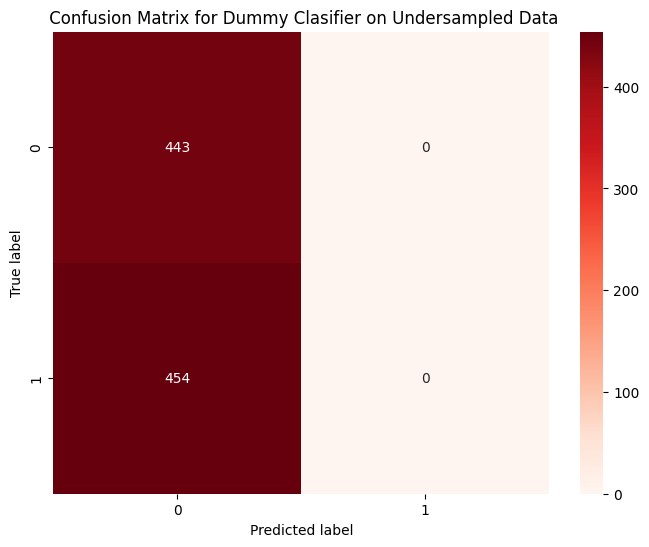

In [ ]:
# Fit Dummy Baseline on undersample training data
baseline.fit(X_train_under, y_train_under)

# Make predictions on the oversampled test set
y_predict_under = baseline.predict(X_test_under)

confusion_mat_under = confusion_matrix(y_test_under, y_predict_under)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_under, annot=True,fmt="d", cmap="Reds")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(' Confusion Matrix for Dummy Clasifier on Undersampled Data')
plt.show()

In [ ]:
print(classification_report(y_test_over, y_predict_over))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6008
           1       0.49      1.00      0.66      5880

    accuracy                           0.49     11888
   macro avg       0.25      0.50      0.33     11888
weighted avg       0.24      0.49      0.33     11888



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(y_test_under, y_predict_under))

              precision    recall  f1-score   support

           0       0.49      1.00      0.66       443
           1       0.00      0.00      0.00       454

    accuracy                           0.49       897
   macro avg       0.25      0.50      0.33       897
weighted avg       0.24      0.49      0.33       897



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(y_test, y_predict_norm))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5937
           1       0.00      0.00      0.00       456

    accuracy                           0.93      6393
   macro avg       0.46      0.50      0.48      6393
weighted avg       0.86      0.93      0.89      6393



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Fit the DummyClassifier to oversampled training data
baseline.fit(X_train_over, y_train_over)

# Predictions using oversampled test set
y_predict_over = baseline.predict(X_test_over)

print('Performance Metrics For Dummy Classifier On Oversampled Data')

# Calculate acc for dummy over
acc_over = accuracy_score(y_test_over, y_predict_over)
print("Accuracy:", acc_over)

# Calculate Prec for dummy over
prec_over = precision_score(y_test_over, y_predict_over)
print("Precision:", prec_over)

# Calculate rec for dummy over
rec_over = recall_score(y_test_over, y_predict_over)
print("Recall:", rec_over)

# Calculate F-1 score for dummy over
f_over_dummy = f1_score(y_test_over, y_predict_over)
print("F1 Score:", f_over_dummy)

# Calculate AUC score for dummy over
au1c_over_dummy = roc_auc_score(y_test_over, y_predict_over)
print("AUC Score:", au1c_over_dummy)

Performance Metrics For Dummy Classifier On Oversampled Data
Accuracy: 0.4946164199192463
Precision: 0.4946164199192463
Recall: 1.0
F1 Score: 0.6618640252138677
AUC Score: 0.5


In [ ]:
# Fit the DummyClassifier to normal training data
baseline.fit(X_train, y_train)

# Predictions test set
y_predict_norm = baseline.predict(X_test)

print('Performance Metrics For Dummy Classifier On Normal Data')

# acc for dummy norm
acc_norm = accuracy_score(y_test, y_predict_norm)
print("Accuracy:", acc_norm)

# prec for dummy norm
prec_norm = precision_score(y_test, y_predict_norm)
print("Precision:", prec_norm)

# rec for dummy norm
rec_norm = recall_score(y_test, y_predict_norm)
print("Recall:", rec_norm)

# F-1 score for dummy norm
f_norm = f1_score(y_test, y_predict_norm)
print("F1 Score:", f_norm)

# AUC score for dummy norm
au2c_norm = roc_auc_score(y_test, y_predict_norm)
print("AUC Score:", au2c_norm)

Performance Metrics For Dummy Classifier On Normal Data
Accuracy: 0.9286719849835758
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
AUC Score: 0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Fit the DummyClassifier to undersampled training data
baseline.fit(X_train_under, y_train_under)

# Predictions test set
y_predict_under = baseline.predict(X_test_under)

print('Performance Metrics For Dummy Classifier On Undersampled Data')

# acc for dummy under
acc_under = accuracy_score(y_test_under, y_predict_under)
print("Accuracy:", acc_under)

# prec for dummy under
prec_under = precision_score(y_test_under, y_predict_under)
print("Precision:", prec_under)

# rec for dummy under
rec_under = recall_score(y_test_under, y_predict_under)
print("Recall:", rec_under)

# F1 for dummy under
f_under = f1_score(y_test_under, y_predict_under)
print("F1 Score:", f_under)

# AUC for dummy under
au3c_under = roc_auc_score(y_test_under, y_predict_under)
print("AUC Score:", au3c_under)

Performance Metrics For Dummy Classifier On Undersampled Data
Accuracy: 0.4938684503901895
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
AUC Score: 0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


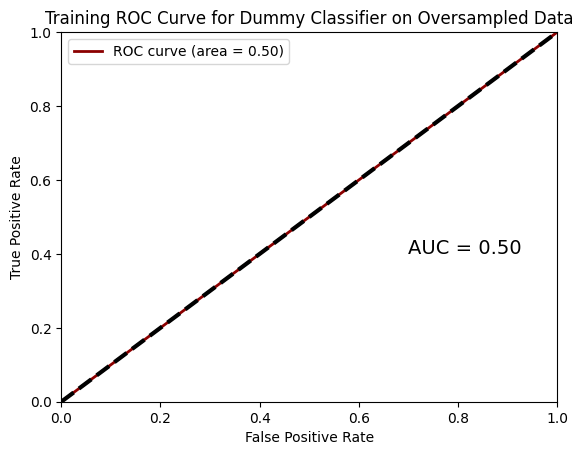

In [ ]:
fp1r_over, tp1r_over, _ = roc_curve(y_test_over,y_predict_over)
ro1c_au1c_over = auc(fp1r_over, tp1r_over)

plt.figure()
plt.plot(fp1r_over, tp1r_over, color='darkred', lw=2, label='ROC curve (area = %0.2f)' % ro1c_au1c_over)
plt.plot([0, 1], [0, 1], color='black', lw=3, linestyle='--')
plt.text(0.7, 0.4, "AUC = %0.2f" % ro1c_au1c_over, fontsize=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training ROC Curve for Dummy Classifier on Oversampled Data')
plt.legend(loc="upper left")
plt.show()

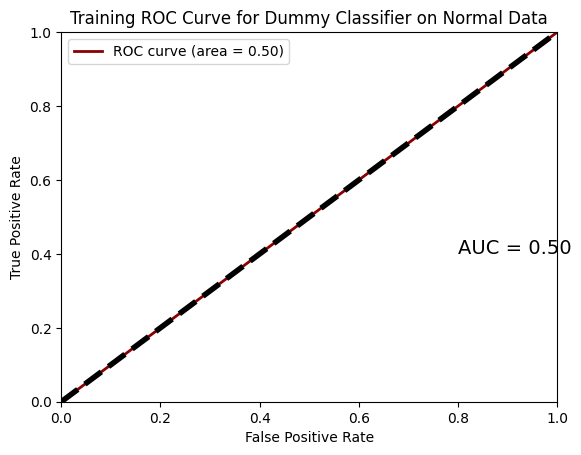

In [ ]:
fp3r_norm, tp3r_norm, _ = roc_curve(y_test,y_predict_norm)
ro2c_au2c_norm = auc(fp3r_norm, tp3r_norm)

plt.figure()
plt.plot(fp3r_norm, tp3r_norm, color='darkred', lw=2, label='ROC curve (area = %0.2f)' % ro2c_au2c_norm)
plt.plot([0, 1], [0, 1], color='black', lw=4, linestyle='--')
plt.text(0.8, 0.4, "AUC = %0.2f" % ro2c_au2c_norm, fontsize=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training ROC Curve for Dummy Classifier on Normal Data')
plt.legend(loc="upper left")
plt.show()

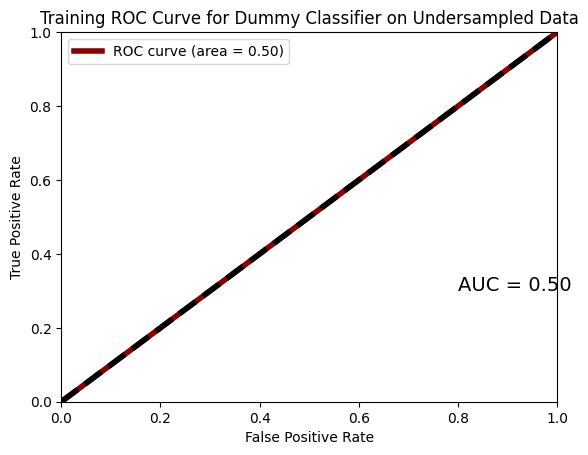

In [ ]:
fp3r_under, tp3r_under, _ = roc_curve(y_test_under,y_predict_under)
ro3c_au3c_under = auc(fp3r_under, tp3r_under)

plt.figure()
plt.plot(fp3r_under, tp3r_under, color='darkred', lw=4, label='ROC curve (area = %0.2f)' % ro3c_au3c_under)
plt.plot([0, 1], [0, 1], color='black', lw=4, linestyle='--')
plt.text(0.8, 0.3, "AUC = %0.2f" % ro3c_au3c_under, fontsize=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training ROC Curve for Dummy Classifier on Undersampled Data')
plt.legend(loc="upper left")
plt.show()

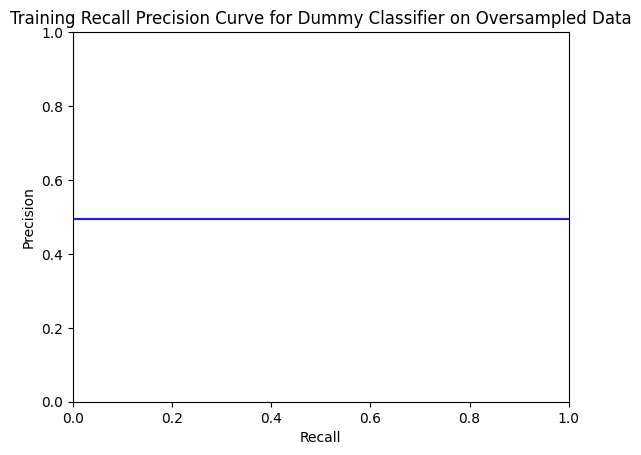

In [ ]:
prec_over, rec_over, _ = precision_recall_curve(y_test_over, y_predict_over)

plt.step(rec_over, prec_over, color='b', alpha=0.9, where='post')

plt.xlabel('Recall')
plt.ylim([0.0, 1.0])
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.title('Training Recall Precision Curve for Dummy Classifier on Oversampled Data')
plt.show()

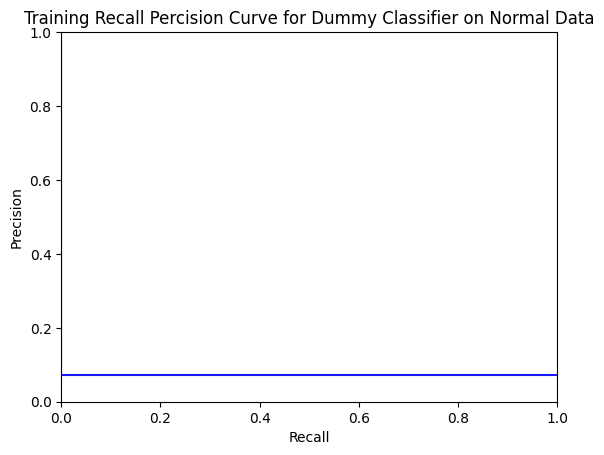

In [ ]:
prec_norm, rec_norm, _ = precision_recall_curve(y_test, y_predict_norm)

plt.step(rec_norm, prec_norm, color='b', alpha=0.9, where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Training Recall Percision Curve for Dummy Classifier on Normal Data')
plt.show()

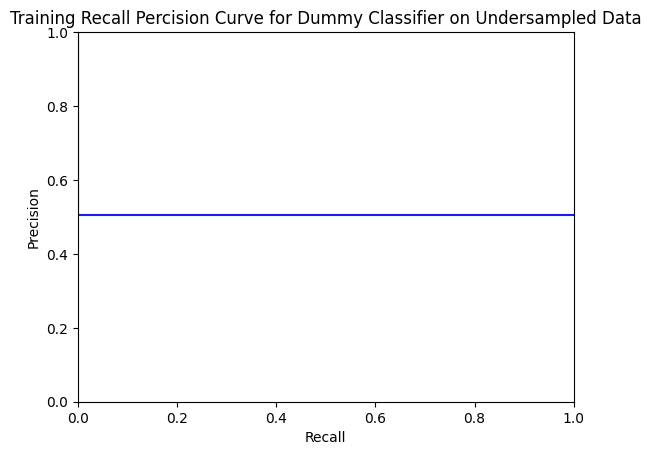

In [ ]:
prec_under, rec_under, _ = precision_recall_curve(y_test_under, y_predict_under)

plt.step(rec_under, prec_under, color='b', alpha=0.9, where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Training Recall Percision Curve for Dummy Classifier on Undersampled Data')
plt.show()

In [ ]:
# SVM + CountVectorizer Pipeline

In [ ]:
lemmas_as_strings5

lemmas_as_strings6

13249    surprise news outlets call opposition racemix ...
4698     good job reduce talented performer physical as...
17302    work develop greencommunity summer fun sustain...
20828    nc monster law make republican lawmakers disen...
22430                    plz sign japan bully tweet 4taiji
                               ...                        
11595    restrict duty like straght jacket pad room loo...
13566    back red hair bepopular bestpicture cute follo...
6826                       comment reflections ignorance c
30865    nice day happy grapes weekend sunshine sun gra...
23899           hot girl sex game white girl sex black guy
Name: lemmas, Length: 11888, dtype: object

In [ ]:
# Define the model with CountVectorizer
svm_pipeline1 = Pipeline([
    ('vect', CountVectorizer()),
    ('svm', SVC())
])

In [ ]:
svm_pipeline1.fit(lemmas_as_strings5, y_train_over)

Pipeline(steps=[('vect', CountVectorizer()), ('svm', SVC())])

In [ ]:
y1_predict_svm1 = svm_pipeline1.predict(lemmas_as_strings6)

In [ ]:
# acc for SVM 1
svm_accuracy1 = accuracy_score(y_test_over, y1_predict_svm1)
print("Accuracy:", svm_accuracy1)

# prec for SVM 1
svm_precision1 = precision_score(y_test_over, y1_predict_svm1)
print("Precision:", svm_precision1)

# rec for SVM 1
svm_recall1 = recall_score(y_test_over, y1_predict_svm1)
print("Recall:", svm_recall1)

# F1 for SVM 1
svm_f11 = f1_score(y_test_over, y1_predict_svm1)
print("F1 Score:", svm_f11)

# AUC for SVM 1
sv1m_auc1 = roc_auc_score(y_test_over, y1_predict_svm1)
print("AUC Score:", sv1m_auc1)

Accuracy: 0.9932705248990579
Precision: 0.9888739042481457
Recall: 0.9976190476190476
F1 Score: 0.993227226549272
AUC Score: 0.9933168473780991


In [ ]:
print(classification_report(y1_predict_svm1, y_test_over))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5956
           1       1.00      0.99      0.99      5932

    accuracy                           0.99     11888
   macro avg       0.99      0.99      0.99     11888
weighted avg       0.99      0.99      0.99     11888



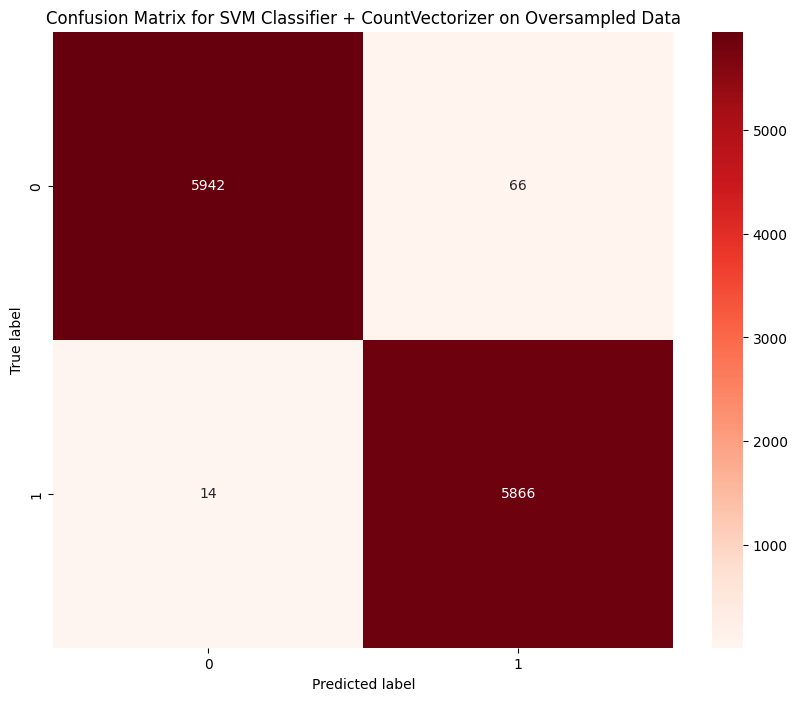

In [ ]:
confusion_mat1_svm1 = confusion_matrix(y_test_over, y1_predict_svm1)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat1_svm1, annot=True, fmt="d", cmap="Reds")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for SVM Classifier + CountVectorizer on Oversampled Data')
plt.show()


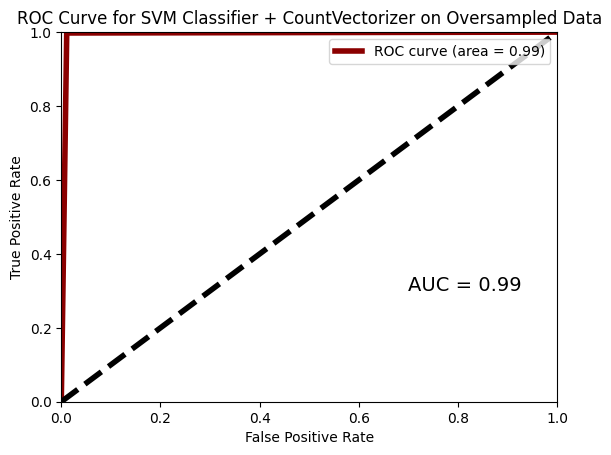

In [ ]:
fp1r_svm1, tp1r_svm1, _ = roc_curve(y_test_over,y1_predict_svm1)
ro1c_au1c_svm1 = auc(fp1r_svm1, tp1r_svm1)

plt.figure()
plt.plot(fp1r_svm1, tp1r_svm1, color='darkred', lw=4, label='ROC curve (area = %0.2f)' % ro1c_au1c_svm1)
plt.plot([0, 1], [0, 1], color='black', lw=4, linestyle='--')
plt.text(0.7, 0.3, "AUC = %0.2f" % ro1c_au1c_svm1, fontsize=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Classifier + CountVectorizer on Oversampled Data')
plt.legend(loc="upper right")
plt.show()

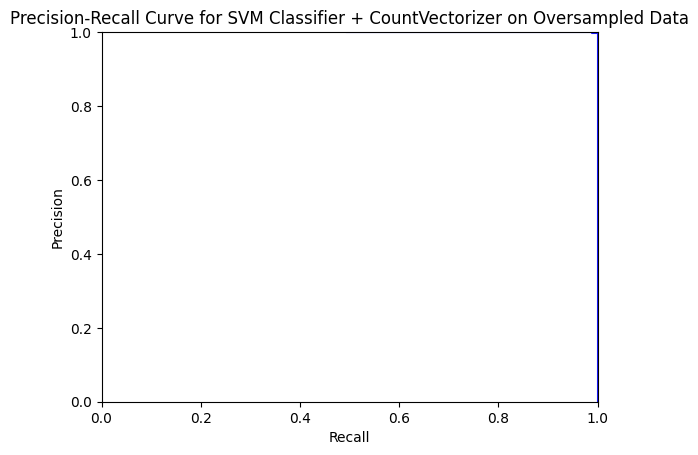

In [ ]:
rec_svm1, prec_svm1, _ = precision_recall_curve(y_test_over, y1_predict_svm1)

plt.step(rec_svm1, prec_svm1, color='b', alpha=0.9, where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for SVM Classifier + CountVectorizer on Oversampled Data')
plt.show()

In [ ]:
# Define the model with TfidfVectorizer
svm_pipeline2 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('svm', SVC())
])

In [ ]:
svm_pipeline2.fit(lemmas_as_strings5, y_train_over)

Pipeline(steps=[('vect', TfidfVectorizer()), ('svm', SVC())])

In [ ]:
y2_predict_svm2 = svm_pipeline2.predict(lemmas_as_strings6)

In [ ]:
# acc for SVM 2
svm_accuracy2 = accuracy_score(y_test_over, y2_predict_svm2)
print("Accuracy:", svm_accuracy2)

# prec for SVM 2
svm_precision2 = precision_score(y_test_over, y2_predict_svm2)
print("Precision:", svm_precision2)

# rec for SVM 2
svm_recall2 = recall_score(y_test_over, y2_predict_svm2)
print("Recall:", svm_recall2)

# F1 for SVM 2
svm_f12 = f1_score(y_test_over, y2_predict_svm2)
print("F1 Score:", svm_f12)

# AUC for SVM 2
svm_auc2 = roc_auc_score(y_test_over, y2_predict_svm2)
print("AUC Score:", svm_auc2)

Accuracy: 0.993943472409152
Precision: 0.9879032258064516
Recall: 1.0
F1 Score: 0.9939148073022313
AUC Score: 0.9940079893475365


In [ ]:
print(classification_report(y2_predict_svm2, y_test_over))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5936
           1       1.00      0.99      0.99      5952

    accuracy                           0.99     11888
   macro avg       0.99      0.99      0.99     11888
weighted avg       0.99      0.99      0.99     11888



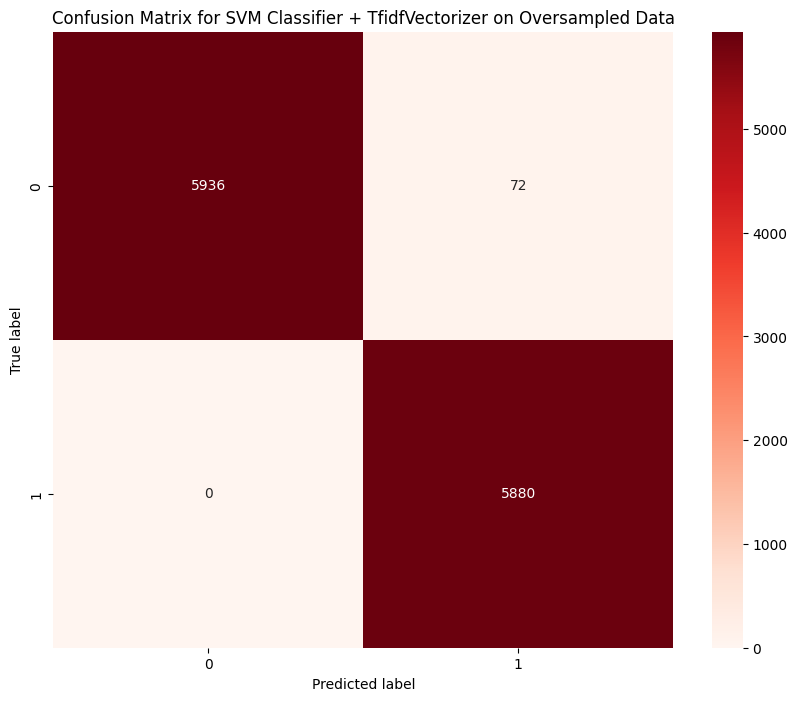

In [ ]:
confus2ion_mat2_svm2 = confusion_matrix(y_test_over, y2_predict_svm2)

plt.figure(figsize=(10, 8))
sns.heatmap(confus2ion_mat2_svm2, annot=True, fmt="d", cmap="Reds")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for SVM Classifier + TfidfVectorizer on Oversampled Data')
plt.show()

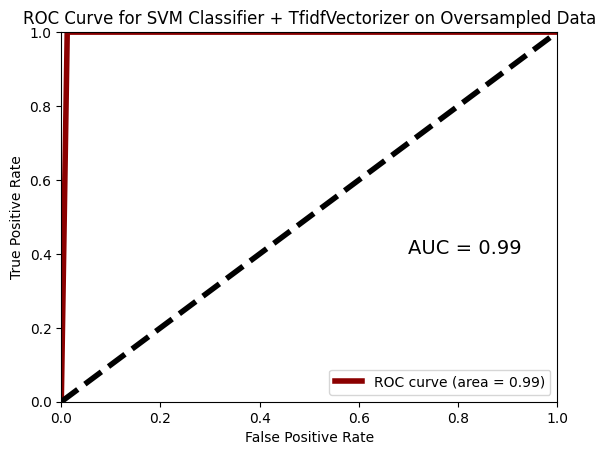

In [ ]:
fp2r_svm2, tp2r_svm2, _ = roc_curve(y_test_over,y2_predict_svm2)
ro2c_au2c_svm2 = auc(fp2r_svm2, tp2r_svm2)

plt.figure()
plt.plot(fp2r_svm2, tp2r_svm2, color='darkred', lw=4, label='ROC curve (area = %0.2f)' % ro2c_au2c_svm2)
plt.plot([0, 1], [0, 1], color='black', lw=4, linestyle='--')
plt.text(0.7, 0.4, "AUC = %0.2f" % ro2c_au2c_svm2, fontsize=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Classifier + TfidfVectorizer on Oversampled Data')
plt.legend(loc="upper right")
plt.show()

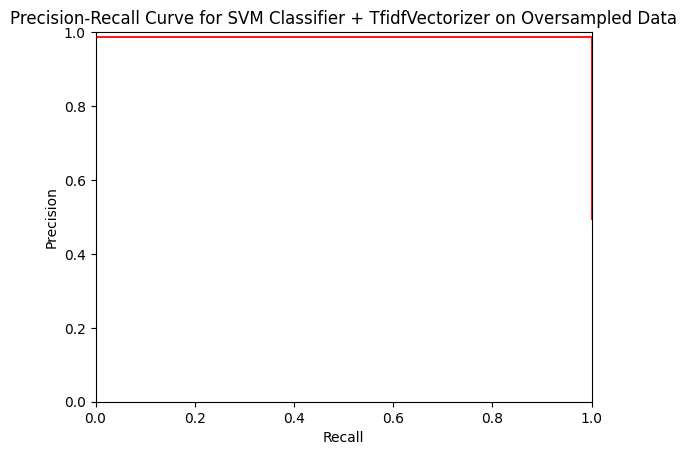

In [ ]:
prec_svm2, rec_svm2, _ = precision_recall_curve(y_test_over, y2_predict_svm2)

plt.step(rec_svm2, prec_svm2, color='r', alpha=0.9, where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Recall Precision Curve for SVM Classifier + TfidfVectorizer on Oversampled Data')
plt.show()

In [ ]:
# Logistic Regression + CountVectorizer Pipeline

In [ ]:
from sklearn.pipeline import Pipeline

lr_pipel1ine = Pipeline([('vect', CountVectorizer()),
                    ('clf', LogisticRegression())])


lr_pipel1ine.fit(lemmas_as_strings5, y_train_over)

Pipeline(steps=[('vect', CountVectorizer()), ('clf', LogisticRegression())])

In [ ]:
y_pr1edict_lr = lr_pipel1ine.predict(lemmas_as_strings6)

In [ ]:
# acc for LR
lr_acc = accuracy_score(y_pr1edict_lr, y_test_over)
print("Accuracy:", lr_acc)

# prec for LR
lr_prec = precision_score(y_pr1edict_lr, y_test_over)
print("Precision:", lr_prec)

# rec for LR
lr_rec = recall_score(y_pr1edict_lr, y_test_over)
print("Recall:", lr_rec)

# F1 for LR
logr_f = f1_score(y_pr1edict_lr, y_test_over)
print("F1 Score:", logr_f)

# AUC for LR
logr_au1c = roc_auc_score(y_pr1edict_lr, y_test_over)
print("AUC Score:", logr_au1c)

Accuracy: 0.9796433378196501
Precision: 0.995578231292517
Recall: 0.9644151565074135
F1 Score: 0.9797489539748954
AUC Score: 0.9799731334273059


In [ ]:
print(classification_report(y_pr1edict_lr, y_test_over))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5818
           1       1.00      0.96      0.98      6070

    accuracy                           0.98     11888
   macro avg       0.98      0.98      0.98     11888
weighted avg       0.98      0.98      0.98     11888



In [ ]:
# XGBoost + Tfid Vectorizer Pipeline

In [ ]:
X1GB_pipeline = Pipeline([
    ('tfidif', TfidfVectorizer()),
    ('xgb', XGBClassifier())
])

In [ ]:
X1GB_pipeline.fit(lemmas_as_strings5, y_train_over)

Pipeline(steps=[('tfidif', TfidfVectorizer()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
y1_predi1ct_XGB = X1GB_pipeline.predict(lemmas_as_strings6)

In [ ]:
y1_predi1ct_XGB

array([1, 1, 0, ..., 1, 0, 1])

In [ ]:
# Few values of y1_predi1ct_XGB and y_test_over
print("y_pred_XGB:", y1_predi1ct_XGB[:10])
print("y_test_over:", y_test_over[:10])

# Unique values in y1_predi1ct_XGB and y_test_over
print("Unique values in y_pred_XGB:", np.unique(y1_predi1ct_XGB))
print("Unique values in y_test_over:", np.unique(y_test_over))

In [ ]:
# acc for XGB 1
XG1B_acc = accuracy_score(y1_predi1ct_XGB, y_test_over)
print("Accuracy:", XG1B_acc)

# prec for XGB 1
XG1B_prec = precision_score(y1_predi1ct_XGB, y_test_over)
print("Precision:", XG1B_prec)

# rec for XGB 1
XG1B_rec = recall_score(y1_predi1ct_XGB, y_test_over)
print("Recall:", XG1B_rec)

# F1 for XGB 1
XG1B_f = f1_score(y1_predi1ct_XGB, y_test_over)
print("F1 Score:", XG1B_f)

# AUC for XGB 1
XG1B_au1c = roc_auc_score(y1_predi1ct_XGB, y_test_over)
print("AUC Score:", XG1B_au1c)

Accuracy: 0.9059555854643337
Precision: 0.8751700680272109
Recall: 0.9305605786618445
F1 Score: 0.9020157756354076
AUC Score: 0.9075577350685756


In [ ]:
print(classification_report(y1_predi1ct_XGB, y_test_over))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      6358
           1       0.88      0.93      0.90      5530

    accuracy                           0.91     11888
   macro avg       0.91      0.91      0.91     11888
weighted avg       0.91      0.91      0.91     11888



In [ ]:
# KN-Neighbours + Tfid Vectorizer Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

KNN_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier(n_neighbors=7))
])
# Grid search was done and n_neighbors= 7 was optimal for this dataset

In [ ]:
KNN_pipeline.fit(lemmas_as_strings5, y_train_over)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('knn', KNeighborsClassifier(n_neighbors=7))])

In [ ]:
y1_pr1ed_KNN = KNN_pipeline.predict(lemmas_as_strings6)

In [ ]:
# acc for KNN 1
KNN1_acc = accuracy_score(y1_pr1ed_KNN, y_test_over)
print("Accuracy:", KNN1_acc)

# prec for KNN 1
KNN1_prec = precision_score(y1_pr1ed_KNN, y_test_over)
print("Precision:", KNN1_prec)

# rec for KNN 1
KNN1_rec = recall_score(y1_pr1ed_KNN, y_test_over)
print("Recall:", KNN1_rec)

# F1 for KNN 1
KNN1_f = f1_score(y1_pr1ed_KNN, y_test_over)
print("F1 Score:", KNN1_f)

# AUC for KNN 1
KNN1_au1c = roc_auc_score(y1_pr1ed_KNN, y_test_over)
print("AUC Score:", KNN1_au1c)

In [ ]:
print(classification_report(y1_pr1ed_KNN, y_test_over))

              precision    recall  f1-score   support

           0       0.41      1.00      0.58      2473
           1       1.00      0.62      0.77      9415

    accuracy                           0.70     11888
   macro avg       0.71      0.81      0.68     11888
weighted avg       0.88      0.70      0.73     11888



Decision Tree Pipeline

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

# Define the pipeline with TfidfVectorizer
decisi2on_tree_pipeline2 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('tree', DecisionTreeClassifier())
])

In [ ]:
# Train the model
decisi2on_tree_pipeline2.fit(lemmas_as_strings5, y_train_over)

# Test the model
y2_predict_decision_tree2 = decisi2on_tree_pipeline2.predict(lemmas_as_strings6)

In [ ]:
# acc for DT 2
DT2_accuracy2 = accuracy_score(y2_predict_decision_tree2, y_test_over)
print("Accuracy:", DT2_accuracy2)

# prec for DT 2
DT2_precision2 = precision_score(y2_predict_decision_tree2, y_test_over)
print("Precision:", DT2_precision2)

# rec for DT 2
DT2_recall2 = recall_score(y2_predict_decision_tree2, y_test_over)
print("Recall:", DT2_recall2)

# F1 for DT 2
DT2_f12 = f1_score(y2_predict_decision_tree2, y_test_over)
print("F1 Score:", DT2_f12)

# AUC for DT 2
DT2_auc2 = roc_auc_score(y2_predict_decision_tree2, y_test_over)
print("AUC Score:", DT2_auc2)

Accuracy: 0.9475100942126514
Precision: 1.0
Recall: 0.9040590405904059
F1 Score: 0.9496124031007752
AUC Score: 0.9520295202952029


In [ ]:
print(classification_report(y2_predict_decision_tree2, y_test_over))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      5384
           1       1.00      0.90      0.95      6504

    accuracy                           0.95     11888
   macro avg       0.95      0.95      0.95     11888
weighted avg       0.95      0.95      0.95     11888



In [ ]:
# Define the pipeline with CountVectorizer
dec1ision_tree_pipeline1 = Pipeline([
    ('vect', CountVectorizer()),
    ('tree', DecisionTreeClassifier())
])


In [ ]:
# Train the model
dec1ision_tree_pipeline1.fit(lemmas_as_strings5, y_train_over)

# Test the model
y1_predict_decision_tree1 = dec1ision_tree_pipeline1.predict(lemmas_as_strings6)

In [ ]:
# Performance Metrics  for DT 1
# acc for DT 1
DT1_accuracy1 = accuracy_score(y1_predict_decision_tree1, y_test_over)
print("Accuracy:", DT1_accuracy1)

# prec for DT 1
DT1_precision1 = precision_score(y1_predict_decision_tree1, y_test_over)
print("Precision:", DT1_precision1)

# rec for DT 1
DT1_recall1 = recall_score(y1_predict_decision_tree1, y_test_over)
print("Recall:", DT1_recall1)

# F1 for DT 1
DT1_f = f1_score(y1_predict_decision_tree1, y_test_over)
print("F1 Score:", DT1_f)

# AUC for DT 1
DT1_auc1 = roc_auc_score(y1_predict_decision_tree1, y_test_over)
print("AUC Score:", DT1_auc1)

Accuracy: 0.9526413189771198
Precision: 1.0
Recall: 0.9126183454912308
F1 Score: 0.9543130731153128
AUC Score: 0.9563091727456154


In [ ]:
print(classification_report(y1_predict_decision_tree1, y_test_over))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5445
           1       1.00      0.91      0.95      6443

    accuracy                           0.95     11888
   macro avg       0.95      0.96      0.95     11888
weighted avg       0.96      0.95      0.95     11888



Random forest

In [ ]:
# Define the pipeline with CountVectorizer
R1F_pipeline1 = Pipeline([
    ('vect', CountVectorizer()),
    ('classifier', RandomForestClassifier())
])

In [ ]:
# Train Random Forest with CountVectorizer
R1F_pipeline1.fit(lemmas_as_strings5, y_train_over)

# Test pipeline
y1_prediction_RF1 = R1F_pipeline1.predict(lemmas_as_strings6)

In [ ]:
# acc for RF 1
R1F_acc1 = accuracy_score(y1_prediction_RF1, y_test_over)
print("Accuracy:", R1F_acc1)

# prec for RF 1
R1F_prec1 = precision_score(y1_prediction_RF1, y_test_over)
print("Precision:", R1F_prec1)

# rec for RF 1
R1F_rec1 = recall_score(y1_prediction_RF1, y_test_over)
print("Recall:", R1F_rec1)

# F1 for RF 1
R1F_f = f1_score(y1_prediction_RF1, y_test_over)
print("F1 Score:", R1F_f)

# AUC for RF 1
R1F_a1uc = roc_auc_score(y1_prediction_RF1, y_test_over)
print("AUC Score:", R1F_a1uc)

Accuracy: 0.9819986541049798
Precision: 1.0
Recall: 0.9648834919593042
F1 Score: 0.9821279438784032
AUC Score: 0.9824417459796522


In [ ]:
print(classification_report(y1_prediction_RF1, y_test_over))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5794
           1       1.00      0.96      0.98      6094

    accuracy                           0.98     11888
   macro avg       0.98      0.98      0.98     11888
weighted avg       0.98      0.98      0.98     11888



In [ ]:
# Define the pipeline with TfidfVectorizer
R2F_pipeline2 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('classifier', RandomForestClassifier())
])

In [ ]:
# Train RF pipeline with TfidfVectorizer
R2F_pipeline2.fit(lemmas_as_strings5, y_train_over)

y2_prediction_RF2 = R2F_pipeline2.predict(lemmas_as_strings6)

In [ ]:
# acc for RF 2
R2F_acc2 = accuracy_score(y2_prediction_RF2, y_test_over)
print("Accuracy:", R2F_acc2)

# prec for RF 2
R2F_prec2 = precision_score(y2_prediction_RF2, y_test_over)
print("Precision:", R2F_prec2)

# rec for RF 2
R2F_rec2 = recall_score(y2_prediction_RF2, y_test_over)
print("Recall:", R2F_rec2)

# F1 for RF 2
RF2_f12 = f1_score(y2_prediction_RF2, y_test_over)
print("F1 Score:", RF2_f12)

# AUC for RF 2
R2F_a2uc = roc_auc_score(y2_prediction_RF2, y_test_over)
print("AUC Score:", R2F_a2uc)

Accuracy: 0.9833445491251682
Precision: 1.0
Recall: 0.9674234945705824
F1 Score: 0.9834420471650778
AUC Score: 0.9837117472852912


In [ ]:
print(classification_report(y2_prediction_RF2, y_test_over))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5810
           1       1.00      0.97      0.98      6078

    accuracy                           0.98     11888
   macro avg       0.98      0.98      0.98     11888
weighted avg       0.98      0.98      0.98     11888



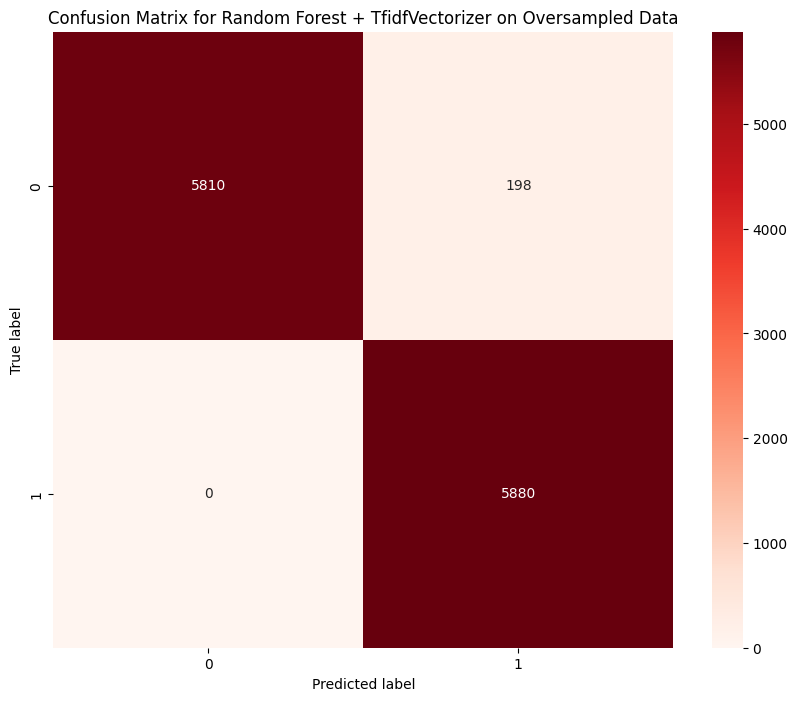

In [ ]:
confus2ion_mat2_RF2 = confusion_matrix(y_test_over, y2_prediction_RF2)

plt.figure(figsize=(10, 8))
sns.heatmap(confus2ion_mat2_RF2, annot=True, fmt="d", cmap="Reds")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest + TfidfVectorizer on Oversampled Data')
plt.show()

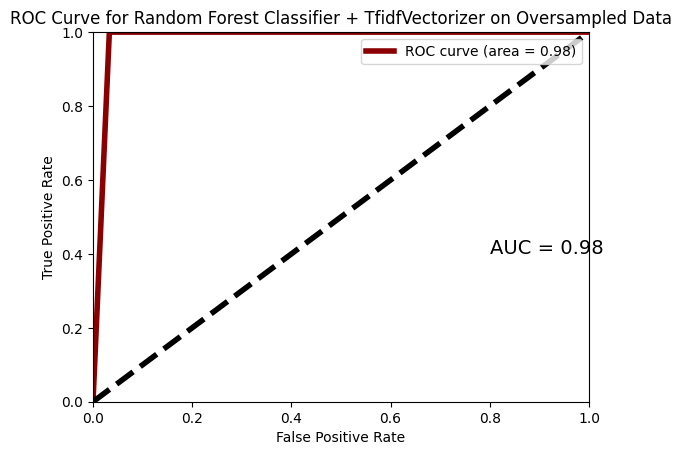

In [ ]:
f2pr_RF2, t2pr_RF2, _ = roc_curve(y_test_over,y2_prediction_RF2)
ro2c_a2uc_RF2 = auc(f2pr_RF2, t2pr_RF2)

plt.figure()
plt.plot(f2pr_RF2, t2pr_RF2, color='darkred', lw=4, label='ROC curve (area = %0.2f)' % ro2c_a2uc_RF2)
plt.plot([0, 1], [0, 1], color='black', lw=4, linestyle='--')
plt.text(0.8, 0.4, "AUC = %0.2f" % ro2c_a2uc_RF2, fontsize=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier + TfidfVectorizer on Oversampled Data')
plt.legend(loc="upper right")
plt.show()

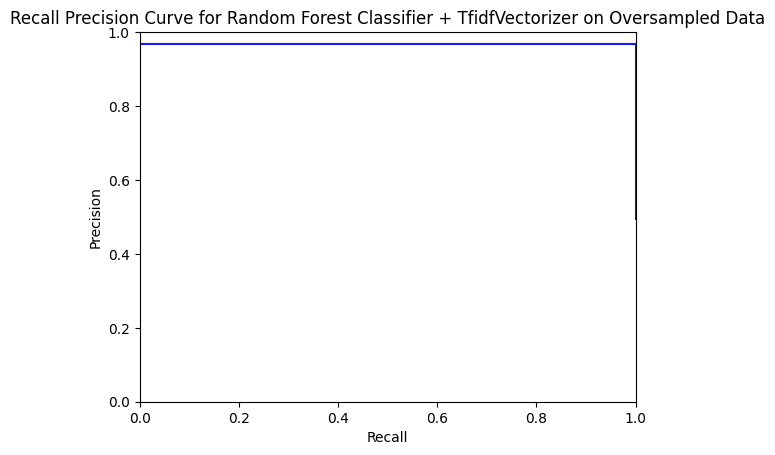

In [ ]:
prec2_RF2, rec2_RF2, _ = precision_recall_curve(y_test_over, y2_prediction_RF2)

plt.step(rec2_RF2, prec2_RF2, color='b', alpha=0.9, where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Recall Precision Curve for Random Forest Classifier + TfidfVectorizer on Oversampled Data')
plt.show()

Multi-Nomial Naive Bayes

In [ ]:
# Define the pipeline with CountVectorizer
M1N_Bayes1_pipeline1 = Pipeline([
    ('vect', CountVectorizer()),
    ('classifier', MultinomialNB())
])

In [ ]:
# Train pipeline with CountVectorizer
M1N_Bayes1_pipeline1.fit(lemmas_as_strings5, y_train_over)

y1_prediction1_MN1 = M1N_Bayes1_pipeline1.predict(lemmas_as_strings6)

In [ ]:
# acc for MN 1
M1N_Bayes_acc1 = accuracy_score(y1_prediction1_MN1, y_test_over)
print("Accuracy:", M1N_Bayes_acc1)

# prec for MN 1
M1N_Bayes_prec1 = precision_score(y1_prediction1_MN1, y_test_over)
print("Precision:", M1N_Bayes_prec1)

# rec for MN 1
M1N_Bayes_rec1 = recall_score(y1_prediction1_MN1, y_test_over)
print("Recall:", M1N_Bayes_rec1)

# F1 for MN 1
M1N_Bayes_f1 = f1_score(y1_prediction1_MN1, y_test_over)
print("F1 Score:", M1N_Bayes_f1)

# AUC for MN 1
M1N_Bayes_auc1 = roc_auc_score(y1_prediction1_MN1, y_test_over)
print("AUC Score:", M1N_Bayes_auc1)

Accuracy: 0.946921265141319
Precision: 0.9773809523809524
Recall: 0.9202562049639712
F1 Score: 0.947958762886598
AUC Score: 0.9483435906974739


In [ ]:
print(classification_report(y1_prediction1_MN1, y_test_over))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5643
           1       0.98      0.92      0.95      6245

    accuracy                           0.95     11888
   macro avg       0.95      0.95      0.95     11888
weighted avg       0.95      0.95      0.95     11888



In [ ]:
# Define the pipeline with TfidfVectorizer
M2N_Bayes_pipeline2 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

In [ ]:
# Train MN with TfidfVectorizer
M2N_Bayes_pipeline2.fit(lemmas_as_strings5, y_train_over)

y2_predict2ion_MN2 = M2N_Bayes_pipeline2.predict(lemmas_as_strings6)

In [ ]:
# acc for MN 2
M2N_Bayes_acc2 = accuracy_score(y2_predict2ion_MN2, y_test_over)
print("Accuracy:", M2N_Bayes_acc2)

# prec for MN 2
M2N_Bayes_prec2 = precision_score(y2_predict2ion_MN2, y_test_over)
print("Precision:", M2N_Bayes_prec2)

# rec for MN 2
M2N_Bayes_rec2 = recall_score(y2_predict2ion_MN2, y_test_over)
print("Recall:", M2N_Bayes_rec2)

# F1 for MN 2
M2N_Bayes_f12 = f1_score(y2_predict2ion_MN2, y_test_over)
print("F1 Score:", M2N_Bayes_f12)

# AUC for MN 2
M2N_Bayes_auc2 = roc_auc_score(y2_predict2ion_MN2, y_test_over)
print("AUC Score:", M2N_Bayes_auc2)

Accuracy: 0.946164199192463
Precision: 0.9870748299319728
Recall: 0.9114321608040201
F1 Score: 0.9477465708687133
AUC Score: 0.9488320224309955


In [ ]:
print(classification_report(y2_predict2ion_MN2, y_test_over))

              precision    recall  f1-score   support

           0       0.91      0.99      0.94      5520
           1       0.99      0.91      0.95      6368

    accuracy                           0.95     11888
   macro avg       0.95      0.95      0.95     11888
weighted avg       0.95      0.95      0.95     11888



Optimisation and Error Analysis of SVM + CountVectorizer pipeline

In [ ]:
import joblib

# Save variables to file
joblib.dump(lemmas_as_strings5, '/content/drive/MyDrive/lemmas_as_strings5.pkl')
joblib.dump(lemmas_as_strings6, '/content/drive/MyDrive/lemmas_as_strings6.pkl')
joblib.dump(y_train_over, '/content/drive/MyDrive/y_train_over.pkl')
joblib.dump(y_test_over, '/content/drive/MyDrive/y_test_over.pkl')
joblib.dump(y2_predict_svm2, '/content/drive/MyDrive/y2_predict_svm2.pkl')

['/content/drive/MyDrive/y2_predict_svm2.pkl']